### DATA CLEANING

1. <b> Remove outliers: </b>
- For each feature for each patient for the total waveform:
    - Calculate the mean
    - Calculate the standard deviation
    - Look at those samples where the value > 10 * standard deviation??: The reason behind this is that normally an outlier is consider as something that is above 3 standard deviations. In this case because we have ill patients we consider bigger standard deviation as plausible values.
    - Subsitute the values where >10 stdandard deviation by NaN
      
2. <b> Looking for features that are not representative: </b>
- Calculate the mean for each patient for the total waveform for each feature
- Create a df where columns are each feature average accross the whole time and rows are each patient
- Look for each feature at the percentage of values that are missing (e.g is 70% it will mean that for 70% of the patients the value of the feature is NaN meaning that there was no data for the whole time for the specific feature)
- Decide on a threshold for a feature to be considered not representative (missing values >70%??)
    - e.g if a feature is missing in more than 70% of the participants we can consider this feature to be non representative and then eliminate the feature
- Eliminate the features that satisfy the threhsold from the analysis

3. <b>Looking for feature stability (to assess whether it makes sense to extract more feature granularity, if a feature is not changing overtime the mean may be representative enough) </b>
- Calculate the mean and the standard deviationfor each patient for the total waveform for each feature
- Extract the coefficient of variation (CV) for each feature and each participant.
The Coefficient is the Normalized Root-Mean-Square Deviation, so we normalize the std deviation to the mean. he higher the coefficient of variation, the greater the level of dispersion around the mean. It is generally expressed as a percentage.
- Decide on a threshold for a CV to be considered variable enough (CV>5%???). For example we may say features that have a CV < 5% we should consider directly the mean, while for the others we can consider to be more granular
- Make a list of the features that satisfy the condition and this feature will be only represented by the mean or the median or whatever.

4. <b> Count the number of samples we have in total for each feature </b>
- For each feature create a column that is the number of total samples
- This will give us an indication of how many values we have per feature, to as well let us know features that have been measured more or less

5. <b> Construct a dataframe given the steps above  </b>
- Each row in the dataframe will be a participant
- Each column in the dataframe will be:
- Features included will be only the ones that were not discarded as being not presentative (e.g < 70% of participants with missing values accross the whole signal)
- Features represented by the total mean if in the analysis above we found that feature is not changing overtime (small coefficient of variation)
- Features represented by hour (eg. HR_hour_1, HR_hour_2.. HR_hour48) if the features have been selected to have enough granularity to be repsented as hourly

In [2]:
import pandas as pd
import pandas as pd
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
def timeit(func):
    """
    Decorator function to measure the execution time of another function.

    Parameters:
        func (callable): The function to be decorated.

    Returns:
        callable: A wrapper function that measures the execution time of the decorated function.
    """
    def wrapper(*args, **kwargs):
        """
        Wrapper function that measures the execution time of the decorated function.

        Parameters:
            *args: Positional arguments to be passed to the decorated function.
            **kwargs: Keyword arguments to be passed to the decorated function.

        Returns:
            Any: The return value of the decorated function.
        """
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' elapsed time: {elapsed_time} seconds")
        return result
    return wrapper


### 1. Looking for non representative features and feature stability

In [4]:
@timeit
def process_time_series_files(time_series_files: list, time_parameters: list, non_time_parameters: list, summary_function: callable) -> pd.DataFrame:
    """
    Process a list of time series files and extract summary statistics for each file using a specified summary function.

    Parameters:
        time_series_files (list): A list of file paths to time series data files.
        time_parameters (list): A list of time parameters to calculate metrics for.
        non_time_parameters (list): A list of non-time parameters to extract values for.
        summary_function (callable): A function to calculate summary statistics for a DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics for all files.
    """
    results = []

    for file_path in time_series_files:
        # Read the file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Extract summary statistics for the DataFrame using the specified summary function
        result = summary_function(df, time_parameters, non_time_parameters)
        
        # Append the result to the results list
        results.append(result)

    # Concatenate results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)
    
    return final_result


In [5]:
# make a list with all time parameters in the dataset
time_parameters =  ['RecordID', 'Age', 'Gender', 'Height','Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol', 
                    'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K',
                    'Lactate', 'Mg', 'MAP', 'MechVent', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 
                 'PaO2',  'pH', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TropI', 'TropT', 'Urine', 'WBC',  'Weight']

non_time_parameters = ['RecordID', 'Age', 'Gender', 'Height']


In [6]:
# store all file paths  in a  list
# Specify the file path using a raw string
files_path = r"..\original_data"
# Use glob to find all .txt files in the directory
time_series_files = glob.glob(str(Path(files_path) / "*.txt"))  # Using Path to construct the file path

# Print the number of files found
print(f"Number of text files: {len(time_series_files)}")
#delete this after demonstration
time_series_files_test = time_series_files[1]
#df = pd.read_csv(time_series_files[1])
time_series_files_test

Number of text files: 8000


'..\\original_data\\132540.txt'

In [7]:
# read target variables
files_outcome_path = r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION\original_data\outcomes"

df_target_a = pd.read_csv(Path(files_outcome_path) / "Outcomes-a.txt")
df_target_b = pd.read_csv(Path(files_outcome_path) / "Outcomes-b.txt")

outcomes_df = pd.concat([df_target_a, df_target_b], ignore_index=True)
outcome_columns = outcomes_df.columns.tolist()
outcome_columns.remove('RecordID')

In [8]:
#functions to process files 
def summaryse_features(df: pd.DataFrame, time_features: list, non_time_features: list) -> pd.DataFrame:
    """
    Calculate the mean value, coefficient of variation (CV), and number of samples for each feature,
    after removing outliers.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        features (list): A list of features to calculate the metrics for.
        non_time_features(list): List of features we need to exclude as they have unique value trhough time

    Returns:
        pd.DataFrame: A DataFrame containing the mean value, coefficient of variation (CV), 
                      and number of samples for each feature after removing outliers.
    """
    # Replace '-1' with NaNs
    df = df.replace(-1.0, np.nan)
    
    # Create dictionaries to store the metrics for each feature
    feature_metrics = {}
    
    # Iterate over each feature
    for feat in time_features:
        # if the feature exists for this participant
        if feat in df['Parameter'].unique():  
            # if the feature is age, gender... just take the mean
            if feat in non_time_features:
                feat_df = df[df['Parameter'] == feat]
                feature_metrics[feat] = feat_df['Value'].iloc[0]
            else:

                # Filter the DataFrame for the current feature
                feat_df = df[df['Parameter'] == feat]

                # Calculate the mean value for the feature
                mean_value = feat_df['Value'].mean()
        
                # Remove outliers
                std_dev = feat_df['Value'].std()
                outlier_threshold = mean_value + 10 * std_dev
                feat_df.loc[feat_df['Value'] > outlier_threshold, 'Value'] = np.nan
                
                # Calculate the coefficient of variation for the feature
                std_dev = feat_df['Value'].std()
                coefficient_of_variation = (std_dev / mean_value) * 100 if mean_value != 0 else np.nan
                
                # Get the number of samples for the feature
                num_samples = feat_df['Value'].count()
                
                # Store the metrics for the feature
                feature_metrics[f'{feat}_mean'] = mean_value
                feature_metrics[f'{feat}_CV'] = coefficient_of_variation
                feature_metrics[f'{feat}_num_samples'] = num_samples
        else:
            # if the feature doesn't exist set the feature parameters as NaN
            feature_metrics[f'{feat}_mean'] = np.nan
            feature_metrics[f'{feat}_CV'] = np.nan
            feature_metrics[f'{feat}_num_samples'] = np.nan
        
    # Create a DataFrame with a single row using the feature_metrics dictionary
    result_df = pd.DataFrame([feature_metrics])
    # convert single features back to integers
    result_df['RecordID'] = result_df['RecordID'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    result_df['Age'] = result_df['Age'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    result_df['Gender'] = result_df['Gender'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    
    return result_df

# save dataframe for feature cleaning
result = process_time_series_files(time_series_files, time_parameters, non_time_parameters, summaryse_features)
result.to_csv("../clean_data/result_for_data_cleaning.csv", index=False)


Function 'process_time_series_files' elapsed time: 154.43393564224243 seconds


In [9]:
#Load dataset
result= pd.read_csv("../clean_data/result_for_data_cleaning.csv") 
# From results data frame calculate the percentaje of NaNs
# Missing values plot
# Filter the DataFrame to include only features with '_mean' in their names
mean_features = [col for col in result.columns if '_mean' in col]
mean_features.extend(non_time_parameters)
# Calculate the total number of values for each mean feature
total_values = result[mean_features].shape[0]


# Calculate the number of NaN values for each mean feature
missing  = result[mean_features].isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / total_values) * 100
missing.index = missing['features']
del missing['features']

# Plot the percentage of NaN values
fig = go.Figure(data=[go.Bar(x=missing.index, y=missing['percent'], marker_color='blue')])
fig.update_layout(title='<b>Missing Values Percent in Dataset</b>',
                  xaxis_title='Features',
                  yaxis_title='Percent',
                  xaxis_tickangle=-90,  # Rotate x-axis labels for better visibility
                  )  # Adjust height of the plot as needed
fig.update_layout(xaxis=dict(tickfont=dict(size=8)))
fig.show()

#### 1.1 Looking for non-representative features
Eliminate columns that satisfy the threshold of 80% of missing value across all participants

In [10]:
missing_threshold = 70
filtered_df = missing[missing['percent'] < missing_threshold]

# Extract the features from the filtered DataFrame
time_parameters_filtered = filtered_df.index.tolist()

# Remove "_mean" suffix from each feature name
time_parameters_filtered = [feature.replace('_mean', '') for feature in time_parameters_filtered]

# Compare which parameters are missing from original time_parameters to new filtered time_parameters list
# Convert lists to sets
original = set(time_parameters)
filtered = set(time_parameters_filtered)

# Find the elements that are different
parameters_to_eliminate = original.symmetric_difference(filtered)
print("Features that have >70% missing values:", parameters_to_eliminate)


Features that have >70% missing values: {'Cholesterol', 'RespRate', 'TropT', 'TropI'}


In [11]:
# List of parameters to eliminate
# Eliminate columns with prefixes defined in the dictionary
columns_to_drop = [col for col in result.columns if any(col.startswith(prefix) for prefix in parameters_to_eliminate)]
result = result.drop(columns=columns_to_drop)
result.shape[1]


103

#### 1.2 Looking for time features with little timepoints

In [12]:
#summaryse CV_Features
CV_features = [col for col in result.columns if '_CV' in col]
# Calculate the total number of values for each mean feature
cv_columns_description = result[CV_features].describe(percentiles=[.25, .50, .75, .90, .95]).round(2)
cv_columns_description.to_csv("cv_columns_description.csv")


In [13]:
# summaryse count features
num_samples_features = [col for col in result.columns if '_num_samples' in col]
# Calculate the total number of values for each mean feature
num_samples_columns_description = result[num_samples_features].describe(percentiles=[.25, .50, .75, .90, .95]).round(2)
num_samples_columns_description.to_csv("num_samples_columns_description.csv")


Comparing number of samples and its coefficient of variation for every feature

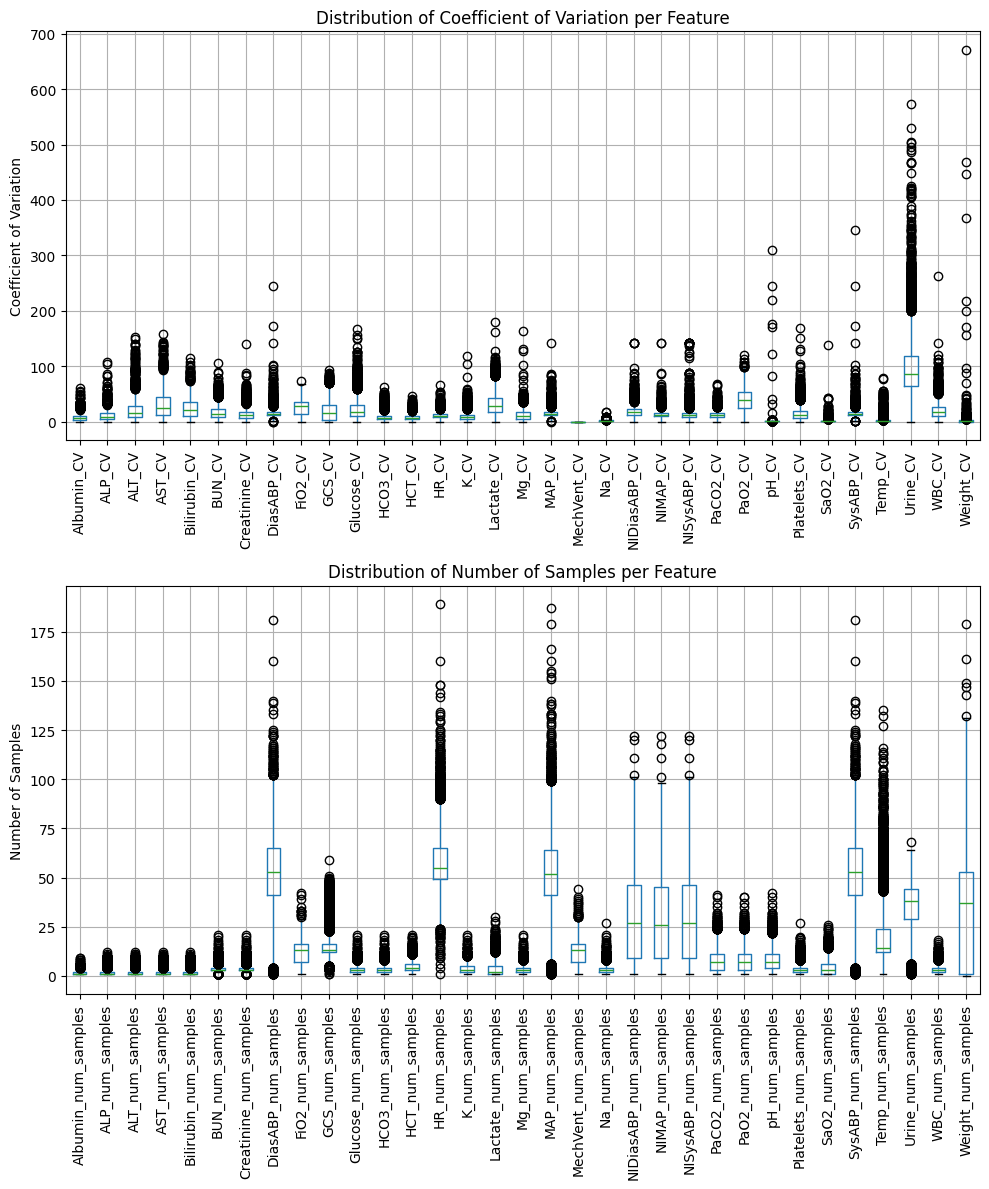

In [14]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot boxplot for coefficient of variation
result[CV_features].boxplot(ax=axes[0])
axes[0].set_title('Distribution of Coefficient of Variation per Feature')
axes[0].set_ylabel('Coefficient of Variation')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Plot boxplot for number of samples
result[num_samples_features].boxplot(ax=axes[1])
axes[1].set_title('Distribution of Number of Samples per Feature')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

We will look for those features that are not time important, where number of samples for the 95% percentile are <=12, for those features we will summaryse per day, rather than per hour.

In [15]:
# Filter the DataFrame to include only features where the 95th percentile is below 12
features_bellow_12_samples = num_samples_columns_description.loc['95%', :][num_samples_columns_description.loc['95%', :] < 13].index.tolist()
# Extract feature names without '_num_samples'
features_every_24 = [feat.replace('_num_samples', '') for feat in features_bellow_12_samples]
print(features_every_24)

['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'HCT', 'K', 'Lactate', 'Mg', 'Na', 'Platelets', 'SaO2', 'WBC']


In [16]:
# find the features to summarise per hour
original = set(time_parameters_filtered)
filtered = set(features_every_24)

# Find the elements that are different and also delete demographic features
features_every_hour = list(original.symmetric_difference(filtered))
features_every_hour = [x for x in features_every_hour if x not in set(non_time_parameters)]

In [17]:
demographic_parameters = non_time_parameters
print(f"Demographic parameter: {demographic_parameters} ({len(demographic_parameters)} elements)\n")
print(f"Outcome columns: {outcome_columns} ({len(outcome_columns)} elements)\n")
print(f"Time parameters every 24 hours: {features_every_24} ({len(features_every_24)} elements)\n")
print(f"Time parameters every hour: {features_every_hour} ({len(features_every_hour)} elements)\n")


Demographic parameter: ['RecordID', 'Age', 'Gender', 'Height'] (4 elements)

Outcome columns: ['SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'] (5 elements)

Time parameters every 24 hours: ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'HCT', 'K', 'Lactate', 'Mg', 'Na', 'Platelets', 'SaO2', 'WBC'] (17 elements)

Time parameters every hour: ['FiO2', 'PaO2', 'pH', 'GCS', 'SysABP', 'MechVent', 'NIMAP', 'PaCO2', 'HR', 'Weight', 'Urine', 'DiasABP', 'MAP', 'NIDiasABP', 'NISysABP', 'Temp'] (16 elements)



In [88]:
def extract_final_data_frame_per_patient(df, features_every_hour, features_every_24, demographic_parameters):
    """
    Extract the values for demographic parameters, features every hour, and features every 24 hours 
    from the given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing time-series data.
        features_every_hour (list): A list of features measured every hour.
        features_every_24 (list): A list of features measured every 24 hours.
        demographic_parameters (list): A list of demographic parameters to extract.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted values for demographic parameters,
                      features every hour, and features every 24 hours.
    """
    # Replace -1.0 with NaN
    df = df.replace(-1.0, np.nan)
    
    # Convert "Time" column to string
    df['Time'] = df['Time'].astype(str)
    
    # Extract hour from "Time" column
    df['Hour'] = df['Time'].str.split(':').str[0].astype(int)
    
    # Pivot the dataframe to have features as columns
    df_pivot = df.pivot_table(index='Hour', columns='Parameter', values='Value', aggfunc='mean')
    
    # Create a new dataframe to store the extracted values
    new_df = pd.DataFrame()
    
    # Extract values for demographic parameters
    demographic_data = {}
    for feature in demographic_parameters:
        if feature in df_pivot.columns:
            demographic_data[feature] = df_pivot[feature].iloc[0]  # Extract the first value
        else:
            demographic_data[feature] = np.nan  # Feature not found, assign NaN
    demographic_df = pd.DataFrame(demographic_data, index=[0])
    
    # Extract mean values for features measured every 24 hours
    features_24hours_data = {}
    features_48hours_data = {}
    for feature in features_every_24:
        if feature in df_pivot.columns:
            # Calculate mean value for 0-24 hours
            features_24hours_data[f'{feature}_24hours'] = df[(df['Hour'] >= 0) & (df['Hour'] <= 24) & (df['Parameter'] == feature)]['Value'].mean()
            
            # Calculate mean value for 25-48 hours
            features_48hours_data[f'{feature}_48hours'] = df[(df['Hour'] >= 25) & (df['Hour'] <= 48) & (df['Parameter'] == feature)]['Value'].mean()
        else:
            features_24hours_data[f'{feature}_24hours'] = np.nan  # Feature not found, assign NaN
            features_48hours_data[f'{feature}_48hours'] = np.nan  # Feature not found, assign NaN

    features_24hours_df = pd.DataFrame(features_24hours_data, index=[0])
    features_48hours_df = pd.DataFrame(features_48hours_data, index=[0])
   
    # Initialize dictionaries to store hourly data
    hourly_data = {}
    
    # Iterate over each feature measured every hour
    for feature in features_every_hour:
        # Check if the feature exists in the DataFrame
        if feature in df_pivot.columns:
            # Iterate over each hour
            for hour in range(1, 49):
                # Calculate the mean value for the current hour
                mean_value = df_pivot.loc[df_pivot.index == hour, feature].mean()
                # Store the mean value in the hourly_data dictionary
                hourly_data[f'{feature}_hour{hour}'] = mean_value
        else:
            # Feature not found, assign NaN for each hour
            for hour in range(1, 49):
                hourly_data[f'{feature}_hour{hour}'] = np.nan
    
    # Create a DataFrame from the hourly data
    hourly_df = pd.DataFrame(hourly_data, index=[0])
    
    # Concatenate all dataframes along columns axis
    final_df = pd.concat([demographic_df, features_24hours_df, features_48hours_df, hourly_df], axis=1)
    
    return final_df

In [29]:
def extract_final_data_frame(time_series_files):
    """
    Process each file in time_series_files and extract demographic values.

    Parameters:
        time_series_files (list): A list of file paths to be processed.

    Returns:
        pd.DataFrame: A DataFrame containing extracted demographic values for each file.
    """
    results = []
    for file_path in time_series_files:
        # Read the file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Extract demographic values from the DataFrame
        extracted_values = extract_final_data_frame_per_patient(df, features_every_hour, features_every_24, demographic_parameters)
        
        # Append the extracted values to the results list
        results.append(extracted_values)
    
    # Concatenate results into a single DataFrame
    final_result = pd.concat(results, axis=0)
    return final_result

In [30]:
# Save the final_result DataFrame to a CSV file 
# Process the files
final_result = extract_final_data_frame(time_series_files)
final_result.to_csv("../clean_data/final_data_frame_for_modeling.csv", index=False)

In [63]:
# From the new data frame calculate the percentaje of NaNs

mean_features =  final_result.columns.tolist()
# Calculate the total number of values for each mean feature
total_values = final_result[mean_features].shape[0]


# Calculate the number of NaN values for each mean feature
missing  = final_result[mean_features].isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / total_values) * 100
missing.index = missing['features']
del missing['features']

# Plot the percentage of NaN values
fig = go.Figure(data=[go.Bar(x=missing.index, y=missing['percent'], marker_color='blue')])
fig.update_layout(title='<b>Missing Values Percent in Dataset</b>',
                  xaxis_title='Features',
                  yaxis_title='Percent',
                  xaxis_tickangle=-90,  # Rotate x-axis labels for better visibility
                  )  # Adjust height of the plot as needed
fig.update_layout(xaxis=dict(tickfont=dict(size=8)))
fig.show()

as there are lot of NaN in the new generated columns we analyze them by groups in order to improve

In [73]:
#analyzing the features_every_24 to see missing values::

features_48 = [col for col in final_result.columns if '48hours' in col]
features_24 = [col for col in final_result.columns if '24hours' in col]
# Calculate the total number of values for each mean feature
# Calculate the percentages of missing values for each feature at 24 hours
missing_24 = final_result[features_24].isna().mean() * 100

# Calculate the percentages of missing values for each feature at 48 hours
missing_48 = final_result[features_48].isna().mean() * 100

# Combine the results into a single DataFrame
missing_combined = pd.DataFrame({
    'Feature': missing_24.index,
    'Missing_24h': missing_24.values,
    'Missing_48h': missing_48.values
})

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Missing_24h', x=missing_combined['Feature'], y=missing_combined['Missing_24h']),
    go.Bar(name='Missing_48h', x=missing_combined['Feature'], y=missing_combined['Missing_48h'])
])

# Customize the chart layout
fig.update_layout(
    title='<b>Percentage of Missing Values for features_every_24</b>',
    xaxis_title='Feature',
    yaxis_title='Percentage',
    xaxis_tickangle=-90,
    barmode='group'  # Group the bars
)

# Show the chart
fig.show()

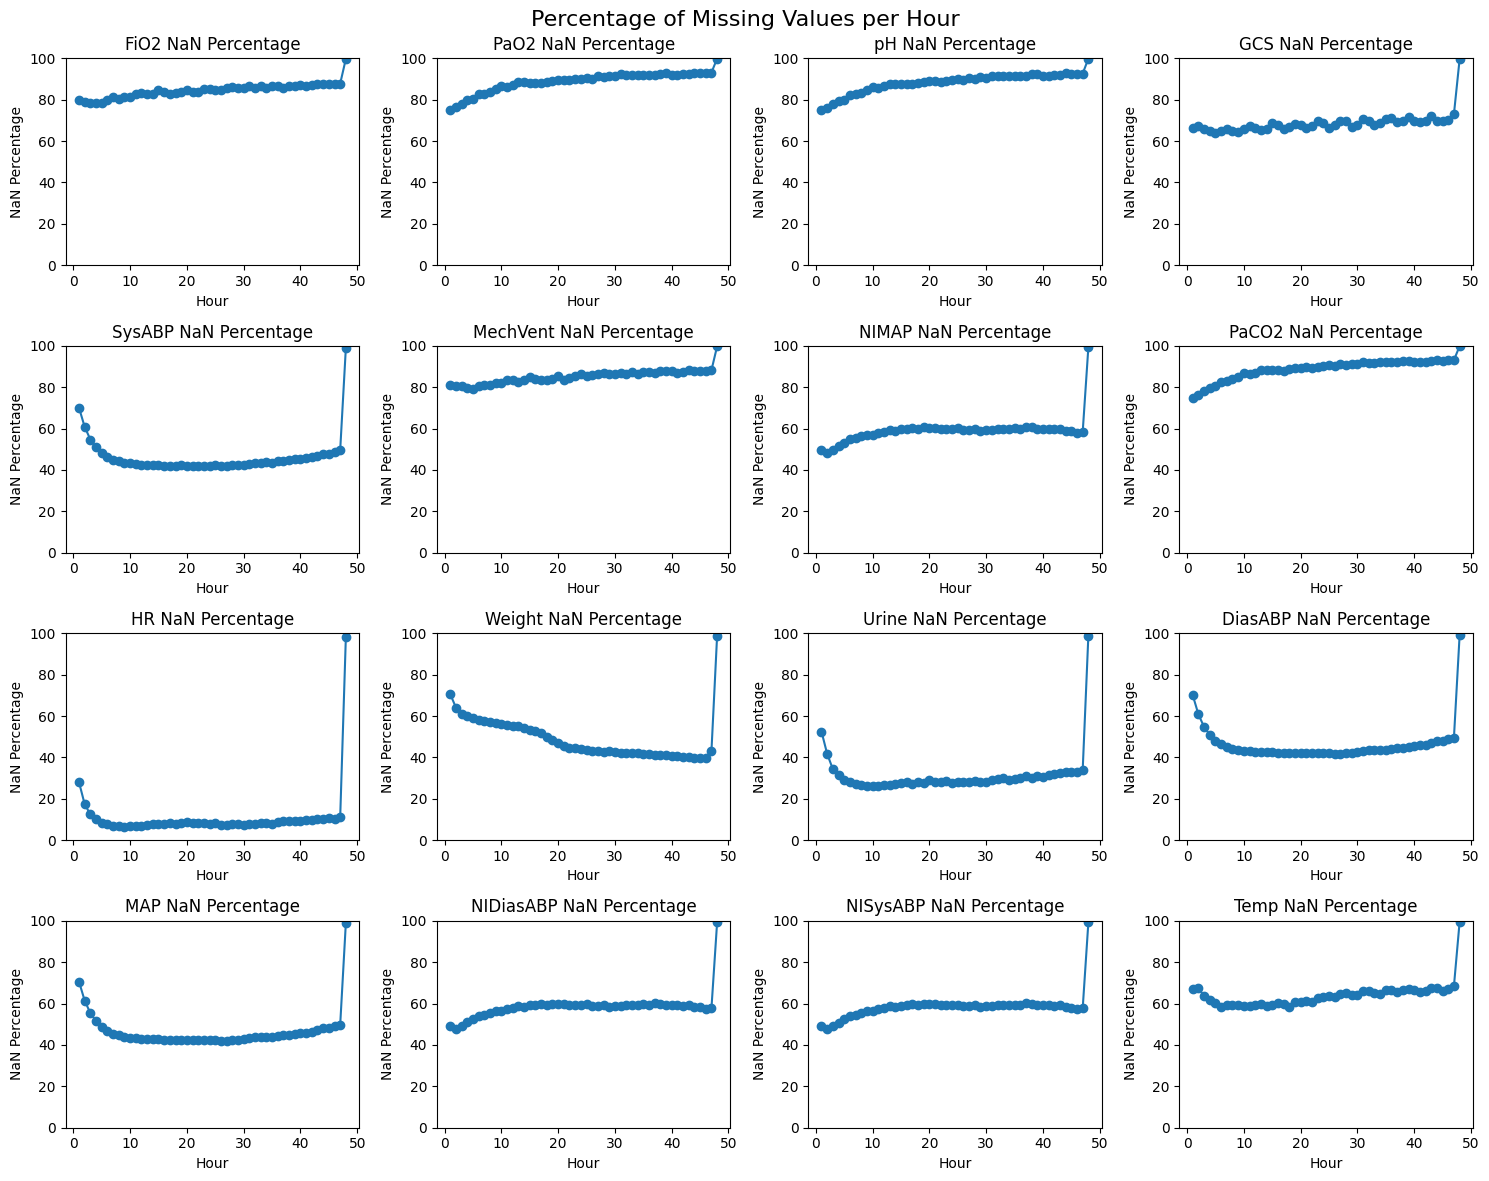

In [86]:
# List to store the names of the features per hour
hourly_feature_names = [f"{feature}_hour{i+1}" for i in range(48) for feature in features_every_hour]

# Create a matrix to store the plots
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.suptitle("Percentage of Missing Values per Hour", fontsize=16)

# Iterate through each feature and its corresponding subplot
for i, feature in enumerate(features_every_hour):
    row, col = divmod(i, 4)  # Calculate the row and column indices
    
    # List to store the percentage of NaN values per hour for the current feature
    nan_percentages = []
    
    # Calculate the percentage of NaN values per hour for the current feature
    for hour in range(1, 49):  # Iterate over the 48 hours
        feature_hour = f"{feature}_hour{hour}"
        nan_percentage = final_result[feature_hour].isna().mean() * 100  # Percentage of NaN
        nan_percentages.append(nan_percentage)
    
    # Plot the percentage of NaN values per hour for the current feature
    axes[row, col].plot(range(1, 49), nan_percentages, marker='o', linestyle='-')
    axes[row, col].set_title(f"{feature} NaN Percentage")
    axes[row, col].set_xlabel("Hour")
    axes[row, col].set_ylabel("NaN Percentage")
    axes[row, col].set_ylim(0, 100)  # Set the y-axis limit
    
# Adjust spacing between subplots
plt.tight_layout()
plt.show()


### 2. Nan imputation

In [1]:
pd.options.display.max_columns=None
result

NameError: name 'pd' is not defined

In [40]:
mean_features = final_result.columns.tolist()
mean_features

['RecordID',
 'Age',
 'Gender',
 'Height',
 'Albumin_24hours',
 'ALP_24hours',
 'ALT_24hours',
 'AST_24hours',
 'Bilirubin_24hours',
 'BUN_24hours',
 'Creatinine_24hours',
 'Glucose_24hours',
 'HCO3_24hours',
 'HCT_24hours',
 'K_24hours',
 'Lactate_24hours',
 'Mg_24hours',
 'Na_24hours',
 'Platelets_24hours',
 'SaO2_24hours',
 'WBC_24hours',
 'Albumin_48hours',
 'ALP_48hours',
 'ALT_48hours',
 'AST_48hours',
 'Bilirubin_48hours',
 'BUN_48hours',
 'Creatinine_48hours',
 'Glucose_48hours',
 'HCO3_48hours',
 'HCT_48hours',
 'K_48hours',
 'Lactate_48hours',
 'Mg_48hours',
 'Na_48hours',
 'Platelets_48hours',
 'SaO2_48hours',
 'WBC_48hours',
 'FiO2_hour1',
 'FiO2_hour2',
 'FiO2_hour3',
 'FiO2_hour4',
 'FiO2_hour5',
 'FiO2_hour6',
 'FiO2_hour7',
 'FiO2_hour8',
 'FiO2_hour9',
 'FiO2_hour10',
 'FiO2_hour11',
 'FiO2_hour12',
 'FiO2_hour13',
 'FiO2_hour14',
 'FiO2_hour15',
 'FiO2_hour16',
 'FiO2_hour17',
 'FiO2_hour18',
 'FiO2_hour19',
 'FiO2_hour20',
 'FiO2_hour21',
 'FiO2_hour22',
 'FiO2_hour2

In [33]:
# concatenate final_result with outcomes to have all the information per patient.



,RecordID,Age,Gender,Height,Albumin_24hours,ALP_24hours,ALT_24hours,AST_24hours,Bilirubin_24hours,BUN_24hours,Creatinine_24hours,Glucose_24hours,HCO3_24hours,HCT_24hours,K_24hours,Lactate_24hours,Mg_24hours,Na_24hours,Platelets_24hours,SaO2_24hours,WBC_24hours,Albumin_48hours,ALP_48hours,ALT_48hours,AST_48hours,Bilirubin_48hours,BUN_48hours,Creatinine_48hours,Glucose_48hours,HCO3_48hours,HCT_48hours,K_48hours,Lactate_48hours,Mg_48hours,Na_48hours,Platelets_48hours,SaO2_48hours,WBC_48hours,FiO2_hour1,FiO2_hour2,FiO2_hour3,FiO2_hour4,FiO2_hour5,FiO2_hour6,FiO2_hour7,FiO2_hour8,FiO2_hour9,FiO2_hour10,FiO2_hour11,FiO2_hour12,FiO2_hour13,FiO2_hour14,FiO2_hour15,FiO2_hour16,FiO2_hour17,FiO2_hour18,FiO2_hour19,FiO2_hour20,FiO2_hour21,FiO2_hour22,FiO2_hour23,FiO2_hour24,FiO2_hour25,FiO2_hour26,FiO2_hour27,FiO2_hour28,FiO2_hour29,FiO2_hour30,FiO2_hour31,FiO2_hour32,FiO2_hour33,FiO2_hour34,FiO2_hour35,FiO2_hour36,FiO2_hour37,FiO2_hour38,FiO2_hour39,FiO2_hour40,FiO2_hour41,FiO2_hour42,FiO2_hour43,FiO2_hour44,FiO2_hour45,FiO2_hour46,FiO2_hour47,FiO2_hour48,PaO2_hour1,PaO2_hour2,PaO2_hour3,PaO2_hour4,PaO2_hour5,PaO2_hour6,PaO2_hour7,PaO2_hour8,PaO2_hour9,PaO2_hour10,PaO2_hour11,PaO2_hour12,PaO2_hour13,PaO2_hour14,PaO2_hour15,PaO2_hour16,PaO2_hour17,PaO2_hour18,PaO2_hour19,PaO2_hour20,PaO2_hour21,PaO2_hour22,PaO2_hour23,PaO2_hour24,PaO2_hour25,PaO2_hour26,PaO2_hour27,PaO2_hour28,PaO2_hour29,PaO2_hour30,PaO2_hour31,PaO2_hour32,PaO2_hour33,PaO2_hour34,PaO2_hour35,PaO2_hour36,PaO2_hour37,PaO2_hour38,PaO2_hour39,PaO2_hour40,PaO2_hour41,PaO2_hour42,PaO2_hour43,PaO2_hour44,PaO2_hour45,PaO2_hour46,PaO2_hour47,PaO2_hour48,pH_hour1,pH_hour2,pH_hour3,pH_hour4,pH_hour5,pH_hour6,pH_hour7,pH_hour8,pH_hour9,pH_hour10,pH_hour11,pH_hour12,pH_hour13,pH_hour14,pH_hour15,pH_hour16,pH_hour17,pH_hour18,pH_hour19,pH_hour20,pH_hour21,pH_hour22,pH_hour23,pH_hour24,pH_hour25,pH_hour26,pH_hour27,pH_hour28,pH_hour29,pH_hour30,pH_hour31,pH_hour32,pH_hour33,pH_hour34,pH_hour35,pH_hour36,pH_hour37,pH_hour38,pH_hour39,pH_hour40,pH_hour41,pH_hour42,pH_hour43,pH_hour44,pH_hour45,pH_hour46,pH_hour47,pH_hour48,GCS_hour1,GCS_hour2,GCS_hour3,GCS_hour4,GCS_hour5,GCS_hour6,GCS_hour7,GCS_hour8,GCS_hour9,GCS_hour10,GCS_hour11,GCS_hour12,GCS_hour13,GCS_hour14,GCS_hour15,GCS_hour16,GCS_hour17,GCS_hour18,GCS_hour19,GCS_hour20,GCS_hour21,GCS_hour22,GCS_hour23,GCS_hour24,GCS_hour25,GCS_hour26,GCS_hour27,GCS_hour28,GCS_hour29,GCS_hour30,GCS_hour31,GCS_hour32,GCS_hour33,GCS_hour34,GCS_hour35,GCS_hour36,GCS_hour37,GCS_hour38,GCS_hour39,GCS_hour40,GCS_hour41,GCS_hour42,GCS_hour43,GCS_hour44,GCS_hour45,GCS_hour46,GCS_hour47,GCS_hour48,SysABP_hour1,SysABP_hour2,SysABP_hour3,SysABP_hour4,SysABP_hour5,SysABP_hour6,SysABP_hour7,SysABP_hour8,SysABP_hour9,SysABP_hour10,SysABP_hour11,SysABP_hour12,SysABP_hour13,SysABP_hour14,SysABP_hour15,SysABP_hour16,SysABP_hour17,SysABP_hour18,SysABP_hour19,SysABP_hour20,SysABP_hour21,SysABP_hour22,SysABP_hour23,SysABP_hour24,SysABP_hour25,SysABP_hour26,SysABP_hour27,SysABP_hour28,SysABP_hour29,SysABP_hour30,SysABP_hour31,SysABP_hour32,SysABP_hour33,SysABP_hour34,SysABP_hour35,SysABP_hour36,SysABP_hour37,SysABP_hour38,SysABP_hour39,SysABP_hour40,SysABP_hour41,SysABP_hour42,SysABP_hour43,SysABP_hour44,SysABP_hour45,SysABP_hour46,SysABP_hour47,SysABP_hour48,MechVent_hour1,MechVent_hour2,MechVent_hour3,MechVent_hour4,MechVent_hour5,MechVent_hour6,MechVent_hour7,MechVent_hour8,MechVent_hour9,MechVent_hour10,MechVent_hour11,MechVent_hour12,MechVent_hour13,MechVent_hour14,MechVent_hour15,MechVent_hour16,MechVent_hour17,MechVent_hour18,MechVent_hour19,MechVent_hour20,MechVent_hour21,MechVent_hour22,MechVent_hour23,MechVent_hour24,MechVent_hour25,MechVent_hour26,MechVent_hour27,MechVent_hour28,MechVent_hour29,MechVent_hour30,MechVent_hour31,MechVent_hour32,MechVent_hour33,MechVent_hour34,MechVent_hour35,MechVent_hour36,MechVent_hour37,MechVent_hour38,MechVent_hour39,MechVent_hour40,MechVent_hour41,MechVent_hour42,MechVent_hour43,MechVent_hour44,MechVent_hour45,MechVent

In [34]:
outcomes_df

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0
...,...,...,...,...,...,...
7995,152849,21,13,6,752,0
7996,152851,28,14,10,39,0
7997,152858,12,4,19,334,0
7998,152862,5,0,12,-1,0
